# AE on CIFAR10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np

import tensorboard
from datetime import datetime

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline

## import data
- import
- normalize

In [22]:
from tensorflow.keras.datasets import cifar10
(X_train, _), (X_test, labels_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [23]:
X_train.shape

(50000, 32, 32, 3)

## build AE

In [24]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import regularizers

encoder

In [25]:
input_img = Input(shape=(32,32,3))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(64, (3, 3), activation='relu', 
                                padding='same')(input_img)
#encoded = Conv2D(64, (3, 3), activation='relu', 
#                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(encoded)
#encoded = Conv2D(32, (3, 3), activation='relu', 
#                                padding='same')(encoded)                                
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)

input_encoded_before_flatten = kb.int_shape(encoded)
encoded = Flatten()(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=kb.int_shape(encoded)[1:])
encoder.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 8)           2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0   

decoder

In [26]:
# model: decoder
decoded = Reshape(input_encoded_before_flatten[1:])(input_encoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
#decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          2336      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 3)         1731

autoencoder

In [27]:
# model: autoencoder
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)
loss = tf.keras.losses.BinaryCrossentropy();

autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_3 (Functional)         (None, 512)               22568     
_________________________________________________________________
model_4 (Functional)         (None, 32, 32, 3)         22563     
Total params: 45,131
Trainable params: 45,131
Non-trainable params: 0
_________________________________________________________________


## train AE

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0005)
ckpt_filepath = 'model/cifar10_ae/checkpoints/cifar10_ae-ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=128,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping,
                    checkpoint,
                    tensorboard_callback], # stop the training when no improvements are made
                verbose=1)

Epoch 1/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5977 - val_loss: 0.5657
Epoch 2/25
391/391 [==============================] - 6s 17ms/step - loss: 0.5637 - val_loss: 0.5618
Epoch 3/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5608 - val_loss: 0.5606
Epoch 4/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5594 - val_loss: 0.5595
Epoch 5/25
391/391 [==============================] - 6s 17ms/step - loss: 0.5590 - val_loss: 0.5592
Epoch 6/25
391/391 [==============================] - 6s 17ms/step - loss: 0.5581 - val_loss: 0.5584
Epoch 7/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5584 - val_loss: 0.5590
Epoch 8/25
391/391 [==============================] - 7s 17ms/step - loss: 0.5578 - val_loss: 0.5574
Epoch 9/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5565 - val_loss: 0.5571
Epoch 10/25
391/391 [==============================] - 6s 16ms/step - loss: 0.5567 - val_lo

In [32]:
# save model
save_filepath = 'model/cifar10_ae/last'
autoencoder.save(
    filepath=save_filepath,
    overwrite=True,
    include_optimizer=True,
)
# load model
loaded_model = tf.keras.models.load_model(save_filepath)

INFO:tensorflow:Assets written to: model/cifar10_ae/last\assets


## show results

In [33]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

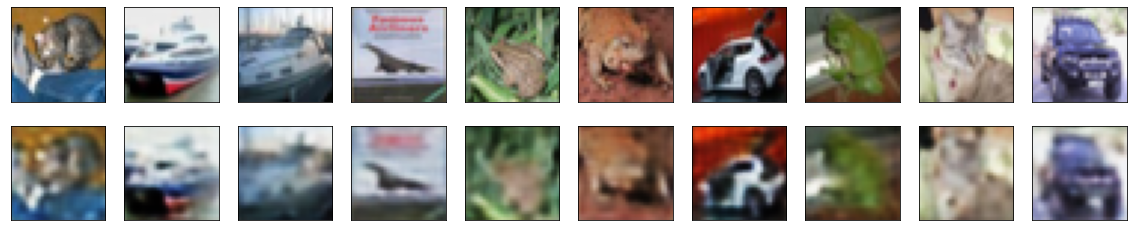

In [34]:
import matplotlib.pyplot as plt

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## combinging labels/categories

tbd

## t-SNE visualization

In [12]:
from sklearn.manifold import TSNE

latent_manifold = TSNE(n_components=2, random_state=33)
latent_points = latent_manifold.fit_transform(encoded_imgs)


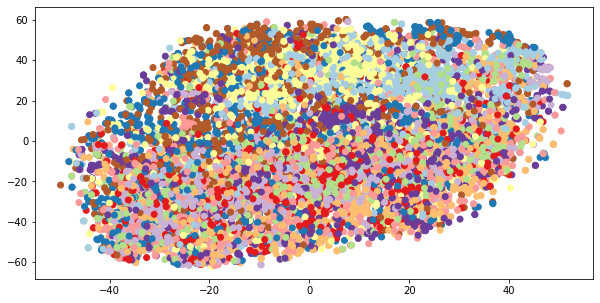

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(latent_points[:, 0], 
    latent_points[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/cifar10_ae/cifar10_tsne.png', dpi=120)
plt.show()

## UMAP visualization

In [12]:
import umap.umap_ as umap
import umap.plot

In [13]:
umap

<module 'umap' from 'C:\\Users\\nanli\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\umap\\__init__.py'>

In [14]:
mapper = umap.UMAP().fit(encoded_imgs)

<AxesSubplot:>

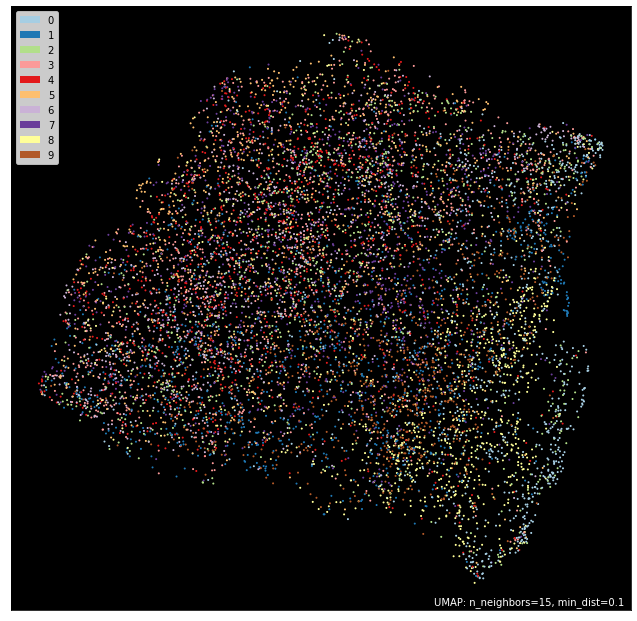

In [19]:
umap.plot.points(mapper, labels=labels_test.reshape(-1,), color_key_cmap='Paired', background='black')

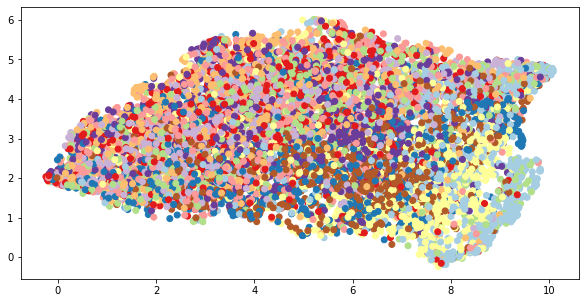

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/cifar10_ae/cifar10_umap.png', dpi=120)
plt.show()

## export architecture

In [42]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 944.

In [43]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1480), started 0:01:59 ago. (Use '!kill 1480' to kill it.)